# An agent to create any two qubit state - fast!

We first setup a simple 2-qubit simulator. Then we initialize an agent that learns to maximize the fidelity between its current state and the target 2-qubit state, that uses temporal difference learning. The agent applies various gates (these are the  possible actions from each state) and tries to minimize the steps taken to achieve, to a high degree of accuracy, the state prescribed to it. The set of gates that the agent found are recorded and then copied onto a qiskit Quantum Circuit - if time permits, we will try to run it on an actual Quantum computer as well - and run. The resulting final state is recorded and we confirm it is quite close to the state intended.

In [424]:
import numpy as np
from qiskit import *
from qiskit.quantum_info import Statevector, Operator, Pauli, state_fidelity
from qiskit.circuit.library.standard_gates import RXGate, RYGate, RZGate, CXGate
from prettytable import PrettyTable
from tqdm import tqdm
import random

In [425]:
class qubit:
    pass
class state:
    pass
class gate:
    pass

In [426]:
class Environment:
    gates = [
        'cnot(0,1)', 'cnot(1,0)', 
        
        'rx(0,pi/4)', 'rx(1,pi/4)', 'rx(0,pi/3)', 'rx(1,pi/3)', 'rx(0,pi/2)', 'rx(1,pi/2)', 
        'rx(0,2pi/3)', 'rx(1,2pi/3)', 'rx(0,pi)', 'rx(1,pi)',

        'ry(0,pi/4)', 'ry(1,pi/4)', 'ry(0,pi/3)', 'ry(1,pi/3)', 'ry(0,pi/2)', 'ry(1,pi/2)', 
        'ry(0,2pi/3)', 'ry(1,2pi/3)', 'ry(0,pi)', 'ry(1,pi)',

        'rz(0,pi/4)', 'rz(1,pi/4)', 'rz(0,pi/3)', 'rz(1,pi/3)', 'rz(0,pi/2)', 'rz(1,pi/2)', 
        'rz(0,2pi/3)', 'rz(1,2pi/3)', 'rz(0,pi)', 'rz(1,pi)'
    ]

    def __init__(self, initial_state, final_state, tol, discount) -> None:
        init_state_cmplx = [complex(initial_state[0], initial_state[4]), complex(initial_state[1], initial_state[5]), complex(initial_state[2], initial_state[6]), complex(initial_state[3], initial_state[7])]
        final_state_cmplx = [complex(final_state[0], final_state[4]), complex(final_state[1], final_state[5]), complex(final_state[2], final_state[6]), complex(final_state[3], final_state[7])]
        print(init_state_cmplx, final_state_cmplx)
        
        self.state = Statevector(init_state_cmplx) # environment maintains the state that the agent is in.
        self.initial_state = Statevector(init_state_cmplx)
        self.final_state = Statevector(final_state_cmplx)
        self.discount = discount
        self.tol = tol
        
        self.terminal_state = None
        self.fidelity = 0
        self.negative_reward = -1
        self.positive_reward = 100
        self.ckt = QuantumCircuit(2)
    
    def available_gates(self): 
        return Environment.gates

    def apply_gate(self, gate):
    #     print(gate)
        if gate == 'cnot(0,1)':
            return self.state.evolve(Operator(Pauli('I')).tensor(Operator([[1,0],[0,0]])) + Operator(Pauli('X')).tensor(Operator([[0,0],[0,1]])))
        elif gate == 'cnot(1,0)':
            return self.state.evolve(Operator(Pauli('I')).tensor(Operator([[1,0],[0,0]])) + Operator(Pauli('X')).tensor(Operator([[0,0],[0,1]])))
        
        elif gate == 'rx(0,pi/4)':
            return self.state.evolve(Operator(Pauli('I')).tensor(Operator(RXGate(np.pi/4))))
        elif gate == 'rx(0,pi/3)':
            return self.state.evolve(Operator(Pauli('I')).tensor(Operator(RXGate(np.pi/3))))
        elif gate == 'rx(0,pi/2)':
            return self.state.evolve(Operator(Pauli('I')).tensor(Operator(RXGate(np.pi/2))))
        elif gate == 'rx(0,2pi/3)':
            return self.state.evolve(Operator(Pauli('I')).tensor(Operator(RXGate(2*np.pi/3))))
        elif gate == 'rx(0,pi)':
            return self.state.evolve(Operator(Pauli('I')).tensor(Operator(RXGate(np.pi))))

        elif gate == 'ry(0,pi/4)':
            return self.state.evolve(Operator(Pauli('I')).tensor(Operator(RYGate(np.pi/4))))
        elif gate == 'ry(0,pi/3)':
            return self.state.evolve(Operator(Pauli('I')).tensor(Operator(RYGate(np.pi/3))))
        elif gate == 'ry(0,pi/2)':
            return self.state.evolve(Operator(Pauli('I')).tensor(Operator(RYGate(np.pi/2))))
        elif gate == 'ry(0,2pi/3)':
            return self.state.evolve(Operator(Pauli('I')).tensor(Operator(RYGate(2*np.pi/3))))
        elif gate == 'ry(0,pi)':
            return self.state.evolve(Operator(Pauli('I')).tensor(Operator(RYGate(np.pi))))

        elif gate == 'rz(0,pi/4)':
            return self.state.evolve(Operator(Pauli('I')).tensor(Operator(RZGate(np.pi/4))))
        elif gate == 'rz(0,pi/3)':
            return self.state.evolve(Operator(Pauli('I')).tensor(Operator(RZGate(np.pi/3))))
        elif gate == 'rz(0,pi/2)':
            return self.state.evolve(Operator(Pauli('I')).tensor(Operator(RZGate(np.pi/2))))
        elif gate == 'rz(0,2pi/3)':
            return self.state.evolve(Operator(Pauli('I')).tensor(Operator(RZGate(2*np.pi/3))))
        elif gate == 'rz(0,pi)':
            return self.state.evolve(Operator(Pauli('I')).tensor(Operator(RZGate(np.pi))))

        elif gate == 'rx(1,pi/4)':
            return self.state.evolve(Operator(RXGate(np.pi/4)).tensor(Operator(Pauli('I'))))
        elif gate == 'rx(1,pi/3)':
            return self.state.evolve(Operator(RXGate(np.pi/3)).tensor(Operator(Pauli('I'))))
        elif gate == 'rx(1,pi/2)':
            return self.state.evolve(Operator(RXGate(np.pi/2)).tensor(Operator(Pauli('I'))))
        elif gate == 'rx(1,2pi/3)':
            return self.state.evolve(Operator(RXGate(2*np.pi/3)).tensor(Operator(Pauli('I'))))
        elif gate == 'rx(1,pi)':
            return self.state.evolve(Operator(RXGate(np.pi)).tensor(Operator(Pauli('I'))))

        elif gate == 'ry(1,pi/4)':
            return self.state.evolve(Operator(RYGate(np.pi/4)).tensor(Operator(Pauli('I'))))
        elif gate == 'ry(1,pi/3)':
            return self.state.evolve(Operator(RYGate(np.pi/3)).tensor(Operator(Pauli('I'))))
        elif gate == 'ry(1,pi/2)':
            return self.state.evolve(Operator(RYGate(np.pi/2)).tensor(Operator(Pauli('I'))))
        elif gate == 'ry(1,2pi/3)':
            return self.state.evolve(Operator(RYGate(2*np.pi/3)).tensor(Operator(Pauli('I'))))
        elif gate == 'ry(1,pi)':
            return self.state.evolve(Operator(RYGate(np.pi)).tensor(Operator(Pauli('I'))))

        elif gate == 'rz(1,pi/4)':
            return self.state.evolve(Operator(RZGate(np.pi/4)).tensor(Operator(Pauli('I'))))
        elif gate == 'rz(1,pi/3)':
            return self.state.evolve(Operator(RZGate(np.pi/3)).tensor(Operator(Pauli('I'))))
        elif gate == 'rz(1,pi/2)':
            return self.state.evolve(Operator(RZGate(np.pi/2)).tensor(Operator(Pauli('I'))))
        elif gate == 'rz(1,2pi/3)':
            return self.state.evolve(Operator(RZGate(2*np.pi/3)).tensor(Operator(Pauli('I'))))
        elif gate == 'rz(1,pi)':
            return self.state.evolve(Operator(RZGate(np.pi)).tensor(Operator(Pauli('I'))))

    def get_fidelity(self):
        self.fidelity =  state_fidelity(self.state, self.final_state)
        return self.fidelity

    def step(self, action_index: int):
        # print('yes')
        self.state = self.apply_gate(self.gates[action_index])
        # print('gotit')
        terminal = self.get_fidelity() > 1 - self.tol
        if terminal:
            return self.positive_reward, self.state, self.discount, terminal
        return self.negative_reward, self.state, self.discount, terminal
        
    def reset(self):
        self.state = self.initial_state

In [427]:
class ReplayBuffer:
    def __init__(self) -> None:
        self.buf: list[tuple] = []

    def add_transition(self, transition: tuple):
        self.buf.append(transition)

    def sample_transition(self):
        return random.choice(self.buf)
    
    def reset(self):
        self.buf = []
    

class Agent:
    def __init__(self, _alpha, _epsilon, _num_offline_updates, _init_state) -> None:
        self.init_state = np.array(_init_state)
        self.num_actions = len(Environment.gates)
        self.weights = np.zeros((self.num_actions, len(_init_state)))
        self.alpha = _alpha
        self.epsilon = _epsilon
        self.replay_buffer = ReplayBuffer()
        self.num_offline_updates = _num_offline_updates
        self.reset()

    def behaviour_policy(self, state):
        exploit = np.random.choice([0, 1], p=[self.epsilon, 1-self.epsilon])
        if exploit:
            return np.argmax(self.q(state))
        else:
            return np.random.choice(range(self.num_actions))


    def q(self, state):
        # print(type(state))
        # print(f"WEIGHTS: {self.weights.size}")
        # print(f"STATE: {state.size}")
        
        return self.weights @ state

    def step(self, reward, discount_factor, next_state):
        self.weights[self.action, :] += self.alpha * (reward + discount_factor*np.max(self.q(next_state)) - self.q(self.state)[self.action]) * self.state
        self.replay_buffer.add_transition((self.state, self.action, reward, discount_factor, next_state))

        for _ in range(self.num_offline_updates):
            s, a, r, g, ns = self.replay_buffer.sample_transition()
            self.weights[a] += self.alpha * (r + g*np.max(self.q(ns)) - self.q(s)[a]) * s

        self.action = self.behaviour_policy(next_state)
        # print(self.q(next_state))
        # print(self.action)
        self.state = next_state
        
        return self.action

    def inference(self, reward, discount_factor, next_state):
        self.action = np.argmax(self.q(next_state))
        self.state = next_state
        return self.action
        
    
    def reset(self):
        self.state = self.init_state
        self.action = self.behaviour_policy(self.state)
        self.replay_buffer.reset()

In [428]:
class Experiment:
    def __init__(self, initial_state, final_state, tol, learning_rate, discount, num_episodes, num_offline_updates, epsilon) -> None:
        self.env = Environment(initial_state, final_state, tol, discount)
        self.num_episodes = num_episodes
        self.agent = Agent(learning_rate, epsilon, num_offline_updates, initial_state)
        self.results = PrettyTable(['Episode #', 'Number of steps', 'fidelity score'])

    def run_episode(self):
        terminal = False
        next_action = self.agent.action     
        while not terminal:
            reward, next_state, discount, terminal = self.env.step(next_action)
            # print(reward, next_state, discount, terminal)
            state_cmplx = next_state.data
            state_real = np.array([
                state_cmplx[0].real, state_cmplx[1].real, state_cmplx[2].real, state_cmplx[3].real, 
                state_cmplx[0].imag, state_cmplx[1].imag, state_cmplx[2].imag, state_cmplx[3].imag
            ])
            next_action = self.agent.step(reward, discount, state_real)
        self.agent.reset()
        # print(self.agent.weights)
        self.env.reset()

    def run_test(self, episode_no):
        terminal = False
        next_action = self.agent.action
        gates_used = []
        while not terminal and len(gates_used) <= 1000:
            gates_used.append(next_action)
            reward, next_state, discount, terminal = self.env.step(next_action)
            state_cmplx = next_state.data
            state_real = np.array([
                state_cmplx[0].real, state_cmplx[1].real, state_cmplx[2].real, state_cmplx[3].real, 
                state_cmplx[0].imag, state_cmplx[1].imag, state_cmplx[2].imag, state_cmplx[3].imag
            ])
            next_action = self.agent.inference(reward, discount, state_real)
        self.agent.reset()

        final_fidelity = self.env.get_fidelity()
        if not terminal:
            return gates_used, self.env.state, final_fidelity
        else:
            self.results.add_row([episode_no, len(gates_used), final_fidelity])
            return gates_used, self.env.terminal_state, self.env.fidelity # why not env.state instead of terminal_state?

    def run_experiment(self):
        # run many episodes, and get the best inference that the agent made
        min_gates = 1e9
        min_gates_list = []
        min_gates_fidelity = 0 # fidelity at min gates
        for ep in tqdm(range(self.num_episodes)):
            self.run_episode() # train agent
            # print('hello')
            gates_used, final_state, final_fidelity = self.run_test(ep)
            if len(gates_used) < min_gates:
                min_gates = len(gates_used)
                min_gates_list = gates_used
                min_gates_fidelity = final_fidelity
        print(self.results)
        return min_gates_list, min_gates_fidelity
        

In [429]:
TOLERANCE = 0.15
NUM_EPISODES = 100
NUM_OFFLINE_UPDATES = 0

ALPHA = 1e-4
EPSILON = 1
NEGATIVE_REWARD = -1
POSITIVE_REWARD = 100
DISCOUNT_FACTOR = 0.5
NUM_EXPERIMENTS = 1

BELL_STATES = [[1/np.sqrt(2), 0, 0, 1/np.sqrt(2), 0, 0, 0, 0], [0, 1/np.sqrt(2), 1/np.sqrt(2), 0, 0, 0, 0, 0], [1/np.sqrt(2), 0, 0, -1/np.sqrt(2), 0, 0, 0, 0], [0, 1/np.sqrt(2), -1/np.sqrt(2), 0, 0, 0, 0, 0]]
# BELL_STATES = [[1/np.sqrt(2), 0, 0, 0, 0, 0, 0, 1/np.sqrt(2), 0, 0, 0, 0, 0, 0, 0, 0]]

In [430]:
for i in range(NUM_EXPERIMENTS):
    initial_state = [1, 0, 0, 0, 0, 0, 0, 0]
    target = BELL_STATES[i]

    print(f"Experiment {i}:")
    exp = Experiment(initial_state, target, TOLERANCE, ALPHA, DISCOUNT_FACTOR, NUM_EPISODES, NUM_OFFLINE_UPDATES, EPSILON)
    ckt_gates, fidelity = exp.run_experiment()

    print(f"Fidelity of the Final Circuit: {fidelity}")
    print([Environment.gates[i] for i in ckt_gates])

Experiment 0:
[(1+0j), 0j, 0j, 0j] [(0.7071067811865475+0j), 0j, 0j, (0.7071067811865475+0j)]


100%|██████████| 100/100 [00:13<00:00,  7.17it/s]

+-----------+-----------------+--------------------+
| Episode # | Number of steps |   fidelity score   |
+-----------+-----------------+--------------------+
|     12    |        6        | 0.8695994598700578 |
|     19    |        2        | 0.9999999999999998 |
|     20    |        58       | 0.8543821660506873 |
|     22    |        75       | 0.9149077078723779 |
|     24    |       102       | 0.8931864043667963 |
|     29    |        16       | 0.8535533905932731 |
|     32    |        7        | 0.8535533905932733 |
|     33    |        37       | 0.8974773944256254 |
|     40    |        30       | 0.9267766952966365 |
|     41    |        29       | 0.8535533905932735 |
|     43    |        41       | 0.8535533905932731 |
|     44    |        30       | 0.9267766952966365 |
|     46    |        44       | 0.8749999999999991 |
|     52    |        6        | 0.9999999999999996 |
|     61    |        63       | 0.8777953264559732 |
|     90    |        41       | 0.860350167396

In [431]:
def create_ckt(num_qubits, gates_list):
    ckt = QuantumCircuit(num_qubits)
    for gate_index in gates_list:
        gate = Environment.gates[gate_index]
        if gate == 'cnot(0,1)':
            ckt.cx(0, 1)            
        elif gate == 'cnot(1,0)':
            ckt.cx(1, 0)
        
        elif gate == 'rx(0,pi/4)':
            ckt.rx(np.pi/4, 0)
        elif gate == 'rx(0,pi/3)':
            ckt.rx(np.pi/3, 0)
        elif gate == 'rx(0,pi/2)':
            ckt.rx(np.pi/2, 0)
        elif gate == 'rx(0,2pi/3)':
            ckt.rx(2*np.pi/3, 0)
        elif gate == 'rx(0,pi)':
            ckt.rx(np.pi, 0)

        elif gate == 'ry(0,pi/4)':
            ckt.ry(np.pi/4, 0)
        elif gate == 'ry(0,pi/3)':
            ckt.ry(np.pi/3, 0)
        elif gate == 'ry(0,pi/2)':
            ckt.ry(np.pi/2, 0)
        elif gate == 'ry(0,2pi/3)':
            ckt.ry(2*np.pi/3, 0)
        elif gate == 'ry(0,pi)':
            ckt.ry(np.pi, 0)

        elif gate == 'rz(0,pi/4)':
            ckt.rz(np.pi/4, 0)
        elif gate == 'rz(0,pi/3)':
            ckt.rz(np.pi/3, 0)
        elif gate == 'rz(0,pi/2)':
            ckt.rz(np.pi/2, 0)
        elif gate == 'rz(0,2pi/3)':
            ckt.rz(2*np.pi/3, 0)
        elif gate == 'rz(0,pi)':
            ckt.rz(np.pi, 0)

        elif gate == 'rx(1,pi/4)':
            ckt.rx(np.pi/4, 1)
        elif gate == 'rx(1,pi/3)':
            ckt.rx(np.pi/3, 1)
        elif gate == 'rx(1,pi/2)':
            ckt.rx(np.pi/2, 1)
        elif gate == 'rx(1,2pi/3)':
            ckt.rx(2*np.pi/3, 1)
        elif gate == 'rx(1,pi)':
            ckt.rx(np.pi, 1)

        elif gate == 'ry(1,pi/4)':
            ckt.ry(np.pi/4, 1)
        elif gate == 'ry(1,pi/3)':
            ckt.ry(np.pi/3, 1)
        elif gate == 'ry(1,pi/2)':
            ckt.ry(np.pi/2, 1)
        elif gate == 'ry(1,2pi/3)':
            ckt.ry(2*np.pi/3, 1)
        elif gate == 'ry(1,pi)':
            ckt.ry(np.pi, 1)

        elif gate == 'rz(1,pi/4)':
            ckt.rz(np.pi/4, 1)
        elif gate == 'rz(1,pi/3)':
            ckt.rz(np.pi/3, 1)
        elif gate == 'rz(1,pi/2)':
            ckt.rz(np.pi/2, 1)
        elif gate == 'rz(1,2pi/3)':
            ckt.rz(2*np.pi/3, 1)
        elif gate == 'rz(1,pi)':
            ckt.rz(np.pi, 1)
    return ckt

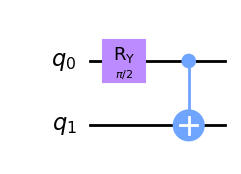

In [432]:
num_qubits = 2
ckt = create_ckt(num_qubits, ckt_gates)
ckt.draw('mpl')

In [433]:
sv = Statevector.from_label('0'*num_qubits) # start in |00>
sv = sv.evolve(ckt)
print(sv.data)

[0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]
